# Correlation analysis

This notebook examines the correlation structure in the gene expression data generated in [1_create_compendia.ipynb](../processing/1_create_compendia.ipynb).

When we performed clustering on the correlation matrices (using Pearson correlation) we found that pairs of genes had either very high correlation scores (>0.5) or very low correlation scores (<0.1). As a result gene pairs that were highly correlated clustered into a single large module. This finding is consistent with a [previous study](https://link.springer.com/article/10.1186/1471-2164-7-187), which found that KEGG (a database that containes genes or proteins annotated with specific biological processes as reported in the literature) is bias in some biological processes represented. Figure 1C demonstrates that a large fraction of gene pairs are ribosomal relationships - in the top 0.1% most co-expressed genes, 99% belong to the ribosome pathway.
Furthermore, protein function prediction based on co-expression drop dramatically after removing the ribisome pathway (Figure 1A, B).

This notebook applies different corrections to try to remove this very dominant global signal in the data. This notebook follows from [1a_transformation_correlation_analysis.ipynb](1a_transformation_correlation_analysis.ipynb). Here we are applying dimensionality reduction techniques in addition to scaling the data.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import plotnine as pn
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
import umap
import random
import numpy as np
import scipy
from sklearn.decomposition import PCA
from core_acc_modules import paths

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Set user parameters

Here we set the number of PCs or singular vectors to use. We are starting with 300 since this is what [eADAGE](https://pubmed.ncbi.nlm.nih.gov/28711280/) used.

In [2]:
# Params
num_PCs = 300
num_PCs_log = 100
num_singular_values = 300
num_singular_values_log = 100

In [3]:
# Load expression data
pao1_compendium_filename = paths.PAO1_COMPENDIUM
pa14_compendium_filename = paths.PA14_COMPENDIUM

In [4]:
pao1_compendium = pd.read_csv(pao1_compendium_filename, sep="\t", header=0, index_col=0)
pa14_compendium = pd.read_csv(pa14_compendium_filename, sep="\t", header=0, index_col=0)

In [5]:
print(pao1_compendium.shape)
pao1_compendium.head()

(847, 5563)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541579,150.908951,63.968306,56.863002,86.013480,32.240954,48.322611,21.099413,21.219456,31.521424,12.168960,...,0.000000,16.606783,38.218939,8.611779,28.396413,110.943698,137.583940,101.058282,65.210599,0.000000
ERX541580,108.323515,56.079007,57.001674,73.421480,18.426169,46.572630,16.606703,18.595344,30.253393,15.936006,...,0.000000,13.904292,37.246074,11.777708,45.733000,94.799523,53.486191,82.753701,23.340646,38.113576
ERX541591,556.704228,182.309588,81.730476,157.348561,85.185006,116.643999,36.964524,31.973493,63.109930,16.140763,...,14.312595,73.032021,80.369628,49.312460,69.099677,61.622295,103.911157,186.030844,478.965167,0.000000
ERX541592,428.470250,178.510235,74.953217,152.142022,92.393069,95.317522,33.668009,31.262234,81.131515,20.126563,...,6.691671,114.618032,62.583672,56.426453,58.473904,55.311934,101.620394,207.409539,345.057960,0.000000
ERX676205,555.932721,530.701952,295.028891,336.887163,160.855884,196.799841,24.062303,127.448405,251.543954,29.933785,...,9.935461,59.660341,268.159400,40.929204,30.272774,284.146647,357.806954,260.651493,110.621722,0.000000


In [6]:
print(pa14_compendium.shape)
pa14_compendium.head()

(520, 5891)


,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
ERX1477379,11.030217,1.370300,0.683438,63.527772,34.586977,4.709054,5.274344,8.137393,5.310585,0.766974,...,10.688588,82.981151,63.650349,28.877599,7.956130,56.829502,269.183334,6.074311,29.079407,100.748813
ERX1477380,13.419626,3.039174,1.334504,105.003820,70.493150,8.849012,6.802855,18.784232,11.978251,2.088495,...,15.823345,91.090917,62.400165,24.819442,3.132517,31.325168,181.774134,10.866863,16.090103,233.317754
ERX1477381,13.155391,5.684725,7.208220,143.201487,107.849795,12.753058,8.868100,27.482294,13.951196,1.251785,...,28.406181,98.909427,71.429549,24.114657,6.515803,18.616579,184.357151,13.112427,13.970424,93.182566
ERX2174773,4.201447,4.194614,3.283683,3.273384,20.188057,3.804287,2.665245,2.650568,20.062716,3.755125,...,41.954387,35.821193,114.727681,104.737209,0.000000,391.722223,160.215744,18.980486,20.985404,182.605858
ERX2174774,5.016892,3.306859,3.446703,2.676762,17.199329,3.748607,1.618736,4.083091,21.225030,2.373772,...,44.138587,26.599121,105.848301,104.402335,0.000000,444.485136,168.538985,24.906987,19.775702,206.865218


## Correlation of raw gene expression data

Here is the correlation of the raw data without any malnipulations. This will serve as a reference to compare the correlations below where applied corrections to the correlations to account for the dominant signal described above.

In [7]:
# Correlation
pao1_corr_original = pao1_compendium.corr()
pa14_corr_original = pa14_compendium.corr()

In [8]:
pao1_corr_original.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
PA0001,1.000000,0.463956,0.569484,0.351438,0.245083,0.082922,-0.237419,0.327681,0.611781,-0.053683,...,-0.143054,0.067547,-0.046884,0.115943,0.095939,0.137961,0.123254,0.413492,-0.017787,-0.044556
PA0002,0.463956,1.000000,0.252376,0.748150,0.165336,-0.064989,-0.223772,0.474954,0.404363,-0.091208,...,-0.049508,-0.029025,0.068886,0.066085,-0.081798,0.364207,0.230212,0.295833,-0.003284,0.026462
PA0003,0.569484,0.252376,1.000000,0.370005,0.231063,0.305920,-0.227813,0.226757,0.414430,0.044911,...,-0.161805,-0.105521,0.058363,-0.032366,0.118532,0.204444,0.136097,0.330368,-0.000470,-0.053666
PA0004,0.351438,0.748150,0.370005,1.000000,0.178458,-0.013829,-0.289639,0.519269,0.406310,-0.039080,...,-0.141347,-0.146768,0.188109,-0.079627,0.004548,0.385017,0.265849,0.248906,-0.068307,-0.074792
PA0005,0.245083,0.165336,0.231063,0.178458,1.000000,0.494013,0.054159,0.548067,0.458342,0.600835,...,0.028263,0.156724,0.147440,0.288880,0.274439,0.158833,-0.076657,0.376051,0.323167,0.055236


In [9]:
pa14_corr_original.head()

,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
PA14_55610,1.000000,0.906701,0.749071,0.162668,0.266153,0.275753,0.588848,0.160785,0.652794,0.713892,...,0.533793,0.227351,0.082841,0.063174,-0.024971,0.059939,-0.029175,0.624167,0.613477,0.070253
PA14_55600,0.906701,1.000000,0.850899,0.156404,0.262327,0.288455,0.564872,0.168042,0.658406,0.723227,...,0.632673,0.222953,0.106674,0.046272,-0.023670,0.043219,-0.103563,0.674299,0.422937,0.040578
PA14_55590,0.749071,0.850899,1.000000,0.130853,0.193168,0.197765,0.359634,0.122212,0.499659,0.527222,...,0.504701,0.143781,0.075238,0.017656,-0.022301,-0.049487,-0.116984,0.452168,0.357768,0.019400
PA14_55580,0.162668,0.156404,0.130853,1.000000,0.715461,0.157864,0.189221,0.072951,0.250444,0.106665,...,0.104985,-0.140209,-0.251613,0.036440,-0.012161,0.073282,-0.040502,0.057864,0.101350,0.067545
PA14_55570,0.266153,0.262327,0.193168,0.715461,1.000000,0.362644,0.379303,0.366620,0.440662,0.297628,...,0.223022,-0.112091,-0.224259,0.063502,-0.031547,0.048680,-0.072413,0.155098,0.139406,0.086553


In [10]:
"""# Plot heatmap
plt.figure(figsize=(20, 20))
o1 = sns.clustermap(pao1_corr_original.abs(), cmap="viridis")
o1.fig.suptitle(f"Correlation of raw PAO1 genes", y=1.05)"""

'# Plot heatmap\nplt.figure(figsize=(20, 20))\no1 = sns.clustermap(pao1_corr_original.abs(), cmap="viridis")\no1.fig.suptitle(f"Correlation of raw PAO1 genes", y=1.05)'

In [11]:
"""# Plot heatmap
plt.figure(figsize=(20, 20))
o2 = sns.clustermap(pa14_corr_original.abs(), cmap="viridis")
o2.fig.suptitle(f"Correlation of raw PA14 genes", y=1.05)"""

'# Plot heatmap\nplt.figure(figsize=(20, 20))\no2 = sns.clustermap(pa14_corr_original.abs(), cmap="viridis")\no2.fig.suptitle(f"Correlation of raw PA14 genes", y=1.05)'

## Correlation of permuted raw gene expression data

Here I am trying to create a null distribution of correlation score to determine if a pair of genes are more correlated than expected. This will still require some thought, but for now this is a first pass.

In [12]:
# Shuffle values per gene
pao1_shuffled_compendium = pao1_compendium.apply(lambda x: x.sample(frac=1).values)
pa14_shuffled_compendium = pa14_compendium.apply(lambda x: x.sample(frac=1).values)

In [13]:
"""# Correlation
pao1_corr_shuffled = pao1_shuffled_compendium.corr()
pa14_corr_shuffled = pa14_shuffled_compendium.corr()"""

'# Correlation\npao1_corr_shuffled = pao1_shuffled_compendium.corr()\npa14_corr_shuffled = pa14_shuffled_compendium.corr()'

In [14]:
"""# Plot heatmap
plt.figure(figsize=(20, 20))
o3 = sns.clustermap(pao1_corr_shuffled.abs(), cmap="viridis")
o3.fig.suptitle(f"Correlation of Shuffled PAO1 genes", y=1.05)"""

'# Plot heatmap\nplt.figure(figsize=(20, 20))\no3 = sns.clustermap(pao1_corr_shuffled.abs(), cmap="viridis")\no3.fig.suptitle(f"Correlation of Shuffled PAO1 genes", y=1.05)'

In [15]:
"""# Plot heatmap
plt.figure(figsize=(20, 20))
o4 = sns.clustermap(pa14_corr_shuffled.abs(), cmap="viridis")
o4.fig.suptitle(f"Correlation of Shuffled PA14 genes", y=1.05)"""

'# Plot heatmap\nplt.figure(figsize=(20, 20))\no4 = sns.clustermap(pa14_corr_shuffled.abs(), cmap="viridis")\no4.fig.suptitle(f"Correlation of Shuffled PA14 genes", y=1.05)'

## SPELL + correlation

_Review of SVD_

Singular Value Decomposition is a way to factorize your matrix, $X^{mxn}$ into singular vectors and singular values: $X = U \Sigma V^*$

In our case $X$ is **gene x sample** and then the columns of $U$ (gene x eigensample) are the left singular vectors (gene coefficient vectors); $\Sigma$ (eigengene x eigensample) has singular values and is diagonal (mode amplitudes); and $V^T$ (eigengene x sample) has rows that are the right singular vectors (expression level vectors).

Here we are using SVD to reduce the noise in our original data by performing dimensionality reduction. This dimensionality is done by neglecting the small singular values in the diagonal matrix $\Sigma$. Normally people would get the projection of the original data onto the singular vectors by $U \Sigma$ and apply the correlation on the projected data. Here, we're following the description in [Hibbs et. al.](https://academic.oup.com/bioinformatics/article/23/20/2692/229926) where they performed correlation on $U$ only.

From [Hibbs et. al.](https://academic.oup.com/bioinformatics/article/23/20/2692/229926), we apply their "signal balancing technique that enhances biological information". This is the first part of their [SPELL](https://spell.yeastgenome.org/) algorithm that is described in section 2.3.1. SPELL calculates the correlation on the gene coefficient matrix, $U$ (i.e. how much genes contribute to a latent variable) that is generated after applying SVD. This matrix represents how genes contribute to independent latent variables that capture the signal in the data where the variance of the variables is 1. The idea is that correlations between gene contributions are more balanced so that less prominent patterns are amplified and more dominant patterns are dampended due to this compression. Figure 3 shows how well SPELL recapitulates biology (i.e. the relationship between genes within a GO term) compared to Pearson correlation.

In [16]:
# Transpose compendia to be gene x sample
# Here we're interested in how genes cluster
pao1_compendium_T = pao1_compendium.T
pa14_compendium_T = pa14_compendium.T

In [17]:
# Apply SVD
pao1_U, pao1_s, pao1_Vh = np.linalg.svd(pao1_compendium_T, full_matrices=False)
pa14_U, pa14_s, pa14_Vh = np.linalg.svd(pa14_compendium_T, full_matrices=False)

In [18]:
print(pao1_compendium_T.shape)
print(pao1_U.shape, pao1_s.shape, pao1_Vh.shape)

(5563, 847)
(5563, 847) (847,) (847, 847)


In the graph, we can see that although we have 847 singular values in s, most of those (after the 20th entry or so) are pretty small. So it might make sense to use only the information related to the first (say, 20) singular values to build a reduced representation.

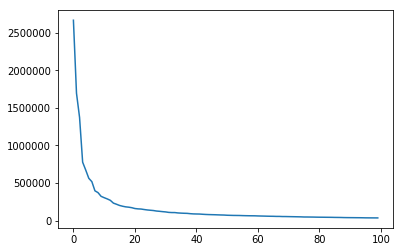

In [19]:
plt.plot(pao1_s[:100])

In [20]:
print(pa14_compendium_T.shape)
print(pa14_U.shape, pa14_s.shape, pa14_Vh.shape)

(5891, 520)
(5891, 520) (520,) (520, 520)


In [21]:
# Convert ndarray to df to use corr()
pao1_U_df = pd.DataFrame(
    data=pao1_U,
    index=pao1_compendium_T.index,  # columns=pao1_compendium.index
)
pa14_U_df = pd.DataFrame(
    data=pa14_U,
    index=pa14_compendium_T.index,  # columns=pa14_compendium.index
)

In [22]:
pao1_U_df.head()

,0,1,2,3,4,5,6,7,8,9,...,837,838,839,840,841,842,843,844,845,846
PA0001,-0.000499,0.003928,0.000161,0.000991,0.004221,0.005287,0.003215,-0.001215,0.000429,-0.003301,...,0.000102,0.026068,0.018979,0.013367,0.007391,0.006881,-0.003159,0.007491,0.002917,-0.012352
PA0002,-0.000571,0.004696,0.000377,0.001109,0.004161,0.007611,0.002265,-0.001126,0.000685,-0.005943,...,0.011190,0.031214,0.038086,-0.017773,0.036547,0.001976,0.008841,0.014507,0.006884,0.019785
PA0003,-0.000410,0.002993,0.000067,0.000592,0.003538,0.003745,0.001793,-0.000601,0.000136,-0.001969,...,0.059264,-0.010148,-0.018930,0.006628,-0.014706,0.000576,-0.005655,0.004718,-0.027775,-0.014643
PA0004,-0.000451,0.003720,0.000140,0.000075,0.003774,0.005970,0.002148,0.000112,0.000226,-0.005934,...,0.001690,0.038703,0.023531,-0.021590,0.032037,0.018646,-0.011879,-0.007102,0.002021,0.013599
PA0005,-0.000138,0.001107,0.000039,0.000043,0.000933,0.001793,0.000557,-0.000328,0.000025,-0.000826,...,-0.017318,-0.006797,0.008385,-0.016335,0.017065,-0.020169,0.001941,0.006049,-0.010133,0.011671


In [23]:
# Correlation of U
# Since `corr()` computes pairwise correlation of columns we need to invert U
pao1_corr_spell = pao1_U_df.iloc[:, :num_singular_values].T.corr()
pa14_corr_spell = pa14_U_df.iloc[:, :num_singular_values].T.corr()

Text(0.5, 1.05, 'Correlation of PAO1 genes (SPELL corrected using 300 vectors)')

<Figure size 1440x1440 with 0 Axes>

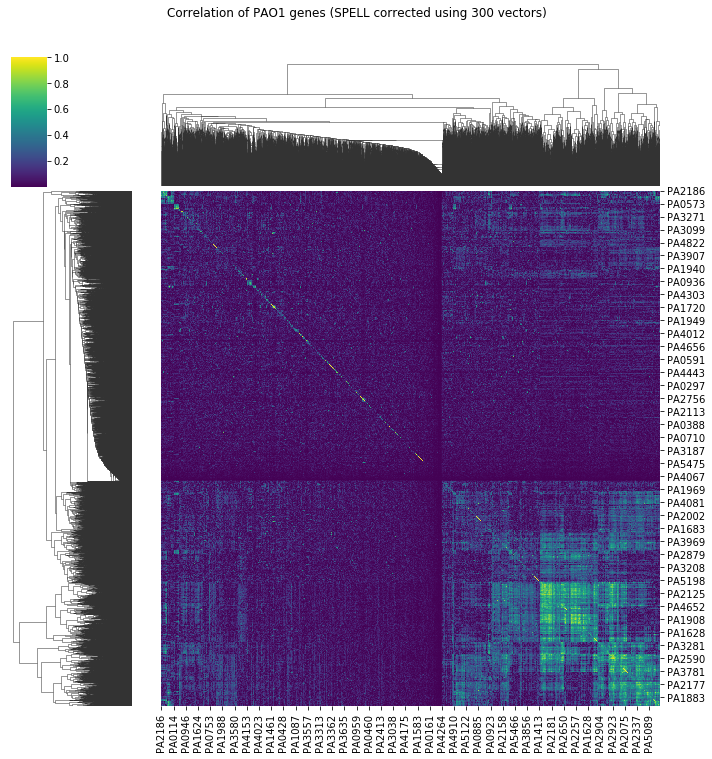

In [24]:
# Plot heatmap
plt.figure(figsize=(20, 20))
h1 = sns.clustermap(pao1_corr_spell.abs(), cmap="viridis")
h1.fig.suptitle(
    f"Correlation of PAO1 genes (SPELL corrected using {num_singular_values} vectors)",
    y=1.05,
)

Text(0.5, 1.05, 'Correlation of PA14 genes (SPELL corrected using 300 vectors)')

<Figure size 1440x1440 with 0 Axes>

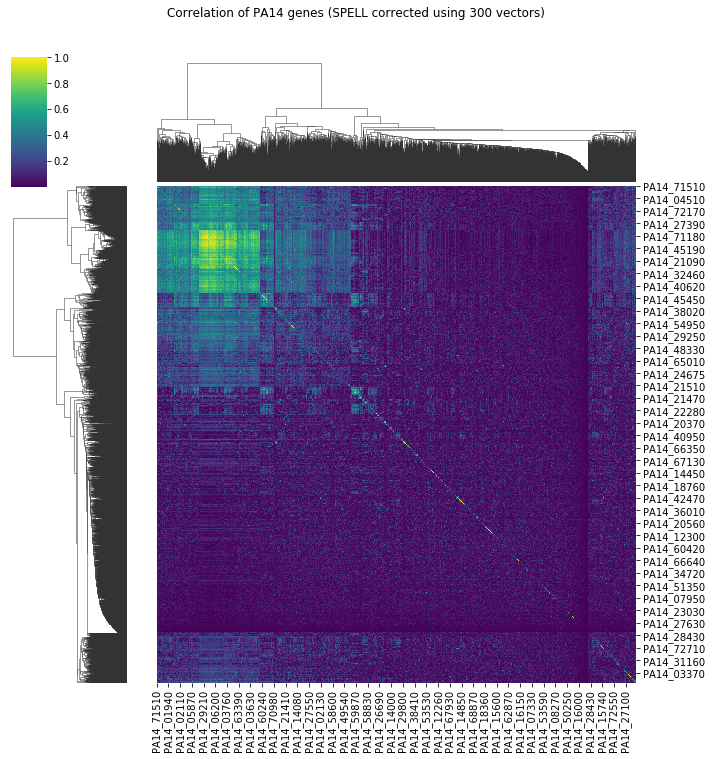

In [25]:
plt.figure(figsize=(20, 20))
h2 = sns.clustermap(pa14_corr_spell.abs(), cmap="viridis")
h2.fig.suptitle(
    f"Correlation of PA14 genes (SPELL corrected using {num_singular_values} vectors)",
    y=1.05,
)

## log transform + SPELL + correlation

In [26]:
# log transform data
pao1_compendium_log10 = np.log10(1 + pao1_compendium_T)
pa14_compendium_log10 = np.log10(1 + pa14_compendium_T)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
# Apply SVD
pao1_U, pao1_s, pao1_Vh = np.linalg.svd(pao1_compendium_log10, full_matrices=False)
pa14_U, pa14_s, pa14_Vh = np.linalg.svd(pa14_compendium_log10, full_matrices=False)

In [29]:
print(pao1_compendium_T.shape)
print(pao1_U.shape, pao1_s.shape, pao1_Vh.shape)

(5563, 847)
(5563, 847) (847,) (847, 847)


In [30]:
print(pa14_compendium_T.shape)
print(pa14_U.shape, pa14_s.shape, pa14_Vh.shape)

(5891, 520)
(5891, 520) (520,) (520, 520)


In [31]:
# Convert ndarray to df to use corr()
pao1_U_df = pd.DataFrame(
    data=pao1_U,
    index=pao1_compendium_T.index,  # columns=pao1_compendium.index
)
pa14_U_df = pd.DataFrame(
    data=pa14_U,
    index=pa14_compendium_T.index,  # columns=pa14_compendium.index
)

In [32]:
# Correlation of U
# Since `corr()` computes pairwise correlation of columns we need to invert U

pao1_corr_spell = pao1_U_df.iloc[:, :num_singular_values].T.corr()
pa14_corr_spell = pa14_U_df.iloc[:, :num_singular_values].T.corr()

In [33]:
"""# Plot heatmap
plt.figure(figsize=(20, 20))
h1a = sns.clustermap(pao1_corr_spell.abs(), cmap="viridis")
h1a.fig.suptitle(
    f"log transform + SPELL corrected using {num_singular_values} vectors (PAO1)",
    y=1.05,
)"""

'# Plot heatmap\nplt.figure(figsize=(20, 20))\nh1a = sns.clustermap(pao1_corr_spell.abs(), cmap="viridis")\nh1a.fig.suptitle(\n    f"log transform + SPELL corrected using {num_singular_values} vectors (PAO1)",\n    y=1.05,\n)'

In [34]:
"""plt.figure(figsize=(20, 20))
h2a = sns.clustermap(pa14_corr_spell.abs(), cmap="viridis")
h2a.fig.suptitle(
    f"log transformed + SPELL corrected using {num_singular_values} vectors (PA14)",
    y=1.05,
)"""

'plt.figure(figsize=(20, 20))\nh2a = sns.clustermap(pa14_corr_spell.abs(), cmap="viridis")\nh2a.fig.suptitle(\n    f"log transformed + SPELL corrected using {num_singular_values} vectors (PA14)",\n    y=1.05,\n)'

## PCA + correlation

Here we are going to calculate the correlation of the gene coefficients, stored in the PC components matrix. We expect this correlation matrix to look very similar to the SPELL results. This is acting as a positive control that we implemented the SPELL correction correctly

In [35]:
# Embed expression data into low dimensional space
pca = PCA(n_components=num_PCs)

model_pao1 = pca.fit(pao1_compendium)

# Using components matrix: gene x PCs (each PC value is how much a gene contributes)
print(model_pao1.components_.shape)
pao1_pc_weights_df = pd.DataFrame(
    data=model_pao1.components_, columns=pao1_compendium.columns
)
pao1_pc_weights_df.head()

(100, 5563)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
0,-0.000317,-0.000394,-0.000213,-0.000314,-0.000110,-0.000072,-0.000057,-0.000129,-0.000092,-0.000034,...,0.000008,-0.000077,-0.000234,-0.000078,-0.000025,-0.000559,0.000433,-0.000101,0.000038,0.003140
1,-0.000374,-0.000635,-0.000229,-0.000345,-0.000092,-0.000024,-0.000098,-0.000128,-0.000100,0.000009,...,-0.000212,-0.000068,-0.000079,-0.000081,-0.000030,-0.001002,-0.001325,-0.000214,-0.000005,0.000674
2,-0.000624,-0.000566,-0.000472,-0.000363,-0.000426,-0.000694,-0.000290,-0.000586,-0.000992,-0.000501,...,-0.001011,-0.000774,-0.000521,-0.000652,-0.000150,-0.000511,0.001524,-0.000891,-0.001594,-0.005870
3,-0.001062,-0.001174,-0.001028,-0.001826,-0.000614,-0.000641,0.000520,-0.000971,-0.001022,-0.000233,...,0.001937,-0.000219,-0.000833,-0.000149,-0.000167,-0.003835,-0.004553,-0.001459,-0.000452,-0.002142
4,0.000576,-0.000628,0.000808,-0.000223,-0.000463,-0.000597,-0.000800,-0.000550,0.000105,-0.000270,...,-0.001596,-0.000084,-0.000287,-0.000363,-0.000025,-0.000274,0.007722,0.000053,-0.000522,-0.002154


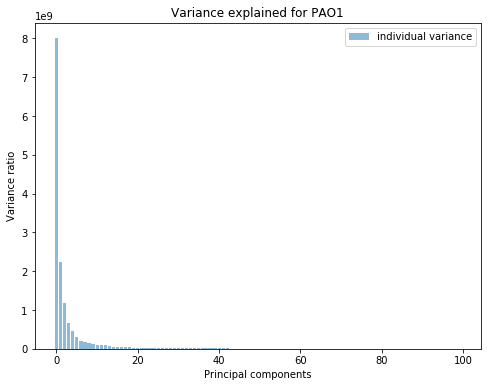

In [36]:
pca_variance = model_pao1.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(
    range(num_PCs), pca_variance, alpha=0.5, align="center", label="individual variance"
)
plt.legend()
plt.title("Variance explained for PAO1")
plt.ylabel("Variance ratio")
plt.xlabel("Principal components")
plt.show()

In [37]:
model_pa14 = pca.fit(pa14_compendium)

# Using components matrix: gene x PCs (each PC value is how much a gene contributes)
print(model_pa14.components_.shape)
pa14_pc_weights_df = pd.DataFrame(
    data=model_pa14.components_, columns=pa14_compendium.columns
)

(100, 5891)


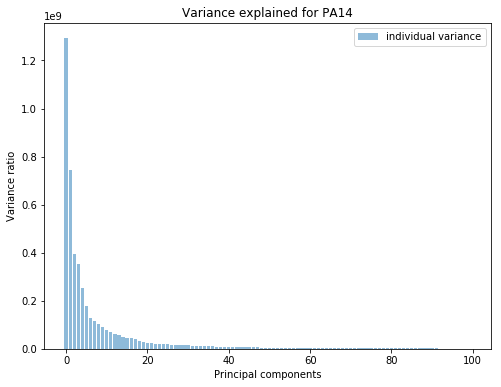

In [38]:
pca_variance = model_pa14.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(
    range(num_PCs), pca_variance, alpha=0.5, align="center", label="individual variance"
)
plt.legend()
plt.title("Variance explained for PA14")
plt.ylabel("Variance ratio")
plt.xlabel("Principal components")
plt.show()

In [39]:
# Correlation
pao1_corr_pca = pao1_pc_weights_df.corr()
pa14_corr_pca = pa14_pc_weights_df.corr()

In [40]:
"""# Plot heatmap
plt.figure(figsize=(20, 20))
h3 = sns.clustermap(pao1_corr_pca.abs(), cmap="viridis")
h3.fig.suptitle(f"PCA using {num_PCs} PCs (PAO1 genes)", y=1.05)"""

'# Plot heatmap\nplt.figure(figsize=(20, 20))\nh3 = sns.clustermap(pao1_corr_pca.abs(), cmap="viridis")\nh3.fig.suptitle(f"PCA using {num_PCs} PCs (PAO1 genes)", y=1.05)'

In [41]:
"""plt.figure(figsize=(20, 20))
h4 = sns.clustermap(pa14_corr_pca.abs(), cmap="viridis")
h4.fig.suptitle(f"PCA using {num_PCs} PCs (PA14 genes)", y=1.05)"""

'plt.figure(figsize=(20, 20))\nh4 = sns.clustermap(pa14_corr_pca.abs(), cmap="viridis")\nh4.fig.suptitle(f"PCA using {num_PCs} PCs (PA14 genes)", y=1.05)'

## log transform + PCA + correlation

In [42]:
# log transform data
# Note: add 1 to avoid -inf and so 0 maps to those
pao1_compendium_log10 = np.log10(1 + pao1_compendium)
pa14_compendium_log10 = np.log10(1 + pa14_compendium)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
# Embed expression data into low dimensional space
pca = PCA(n_components=num_PCs)

model_pao1 = pca.fit(pao1_compendium_log10)

# Using components matrix: gene x PCs (each PC value is how much a gene contributes)
print(model_pao1.components_.shape)
pao1_pc_weights_df = pd.DataFrame(
    data=model_pao1.components_, columns=pao1_compendium_log10.columns
)
pao1_pc_weights_df.head()

(100, 5563)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
0,-0.001060,-0.001833,-0.000970,-0.001473,0.006255,0.007449,0.008832,0.004597,0.002942,0.010938,...,0.018222,0.010323,0.002783,0.010006,-0.001628,-0.003429,-0.005106,0.000580,0.009525,-0.007736
1,-0.012394,-0.008492,-0.012279,-0.013326,-0.016059,-0.012413,0.020562,-0.020205,-0.024540,-0.010626,...,0.038426,0.003904,-0.001539,0.003036,-0.006780,-0.015838,-0.013067,-0.014300,-0.008941,-0.002138
2,-0.007824,-0.010257,-0.000908,-0.002095,-0.009840,0.006488,-0.013283,-0.010262,-0.015970,-0.010938,...,-0.056057,-0.017137,0.012669,-0.022020,0.014427,-0.008724,0.011613,-0.009487,0.006231,-0.017838
3,-0.002337,-0.007182,-0.000686,-0.007628,-0.001563,0.009636,-0.007800,-0.005593,-0.001614,0.003666,...,-0.018723,-0.018173,-0.020902,-0.010096,-0.024656,-0.002931,-0.040671,0.006411,0.013069,0.024577
4,-0.004753,0.001434,0.001124,0.003610,0.000891,0.000146,0.002452,-0.000596,0.009601,0.011952,...,0.015384,0.004873,0.020642,0.011103,-0.041610,0.016474,0.031931,0.004020,0.015714,0.002079


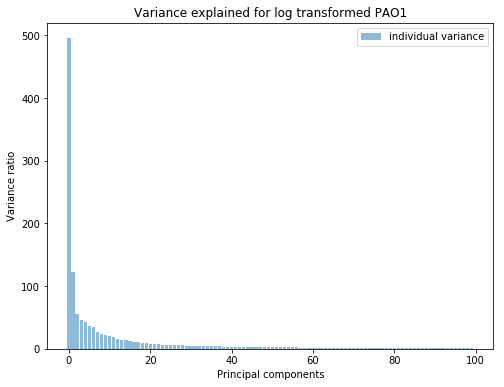

In [45]:
pca_variance = model_pao1.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(
    range(num_PCs), pca_variance, alpha=0.5, align="center", label="individual variance"
)
plt.legend()
plt.title("Variance explained for log transformed PAO1")
plt.ylabel("Variance ratio")
plt.xlabel("Principal components")
plt.show()

In [46]:
model_pa14 = pca.fit(pa14_compendium_log10)
pa14_encoded = model_pa14.transform(pa14_compendium_log10)

# Using components matrix: gene x PCs (each PC value is how much a gene contributes)
print(model_pa14.components_.shape)
pa14_pc_weights_df = pd.DataFrame(
    data=model_pa14.components_, columns=pa14_compendium_log10.columns
)

(100, 5891)


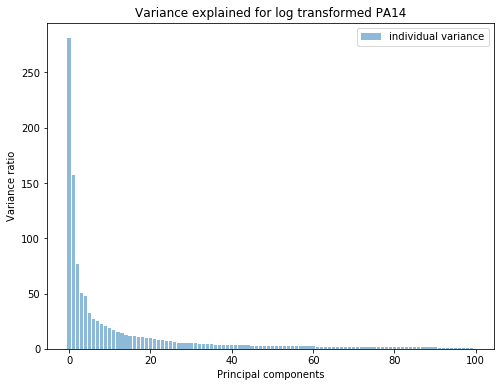

In [47]:
pca_variance = model_pa14.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(
    range(num_PCs), pca_variance, alpha=0.5, align="center", label="individual variance"
)
plt.legend()
plt.title("Variance explained for log transformed PA14")
plt.ylabel("Variance ratio")
plt.xlabel("Principal components")
plt.show()

In [48]:
# Correlation
pao1_corr_pca = pao1_pc_weights_df.corr()
pa14_corr_pca = pa14_pc_weights_df.corr()

In [49]:
"""# Plot heatmap
plt.figure(figsize=(20, 20))
h3a = sns.clustermap(pao1_corr_pca.abs(), cmap="viridis")
h3a.fig.suptitle(f"log transformed + PCA using {num_PCs} PCs (PAO1 genes)", y=1.05)"""

'# Plot heatmap\nplt.figure(figsize=(20, 20))\nh3a = sns.clustermap(pao1_corr_pca.abs(), cmap="viridis")\nh3a.fig.suptitle(f"log transformed + PCA using {num_PCs} PCs (PAO1 genes)", y=1.05)'

In [50]:
"""plt.figure(figsize=(20, 20))
h4a = sns.clustermap(pa14_corr_pca.abs(), cmap="viridis")
h4a.fig.suptitle(f"log transformed + PCA using {num_PCs} PCs (PA14 genes)", y=1.05)"""

'plt.figure(figsize=(20, 20))\nh4a = sns.clustermap(pa14_corr_pca.abs(), cmap="viridis")\nh4a.fig.suptitle(f"log transformed + PCA using {num_PCs} PCs (PA14 genes)", y=1.05)'

## SEEK + correlation

From [Zhu et. al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4768301/), we apply their "gene hubbiness correction" procedure. This is part of their [SEEK](https://seek.princeton.edu/seek/) algorithm. This correction procedure is motivated by the observation that hubby or well-connected genes in the co-expression network represent global, well-co-expressed processes, and can contaminate the search results regardless of query composition due to the effect of unbalanced gene connectivity in a scale-free co-expression network, and can lead to non-specific results in search or clustering approaches. To avoid the bias created by hubby genes they correct for each gene g’s correlation by subtracting g's average correlation.

We noticed that the corrected correlation matrix is not symmetric anymore because we are subtracting the mean for each row. Instead we will normalize the correlation scores per gene

In [51]:
# 0-1 normalize per gene
scaler = preprocessing.MinMaxScaler()

pao1_corr_scaled = scaler.fit_transform(pao1_corr_original)
pa14_corr_scaled = scaler.fit_transform(pa14_corr_original)

pao1_corr_seek = pd.DataFrame(
    pao1_corr_scaled, columns=pao1_corr_original.columns, index=pao1_corr_original.index
)
pa14_corr_seek = pd.DataFrame(
    pa14_corr_scaled, columns=pa14_corr_original.columns, index=pa14_corr_original.index
)

In [52]:
pao1_corr_original.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
PA0001,1.000000,0.463956,0.569484,0.351438,0.245083,0.082922,-0.237419,0.327681,0.611781,-0.053683,...,-0.143054,0.067547,-0.046884,0.115943,0.095939,0.137961,0.123254,0.413492,-0.017787,-0.044556
PA0002,0.463956,1.000000,0.252376,0.748150,0.165336,-0.064989,-0.223772,0.474954,0.404363,-0.091208,...,-0.049508,-0.029025,0.068886,0.066085,-0.081798,0.364207,0.230212,0.295833,-0.003284,0.026462
PA0003,0.569484,0.252376,1.000000,0.370005,0.231063,0.305920,-0.227813,0.226757,0.414430,0.044911,...,-0.161805,-0.105521,0.058363,-0.032366,0.118532,0.204444,0.136097,0.330368,-0.000470,-0.053666
PA0004,0.351438,0.748150,0.370005,1.000000,0.178458,-0.013829,-0.289639,0.519269,0.406310,-0.039080,...,-0.141347,-0.146768,0.188109,-0.079627,0.004548,0.385017,0.265849,0.248906,-0.068307,-0.074792
PA0005,0.245083,0.165336,0.231063,0.178458,1.000000,0.494013,0.054159,0.548067,0.458342,0.600835,...,0.028263,0.156724,0.147440,0.288880,0.274439,0.158833,-0.076657,0.376051,0.323167,0.055236


In [53]:
pao1_corr_seek.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
PA0001,1.000000,0.623644,0.683970,0.560340,0.468001,0.360272,0.150537,0.539471,0.748462,0.265675,...,0.117731,0.267507,0.210688,0.336941,0.290006,0.378736,0.336395,0.589201,0.235803,0.081619
PA0002,0.620878,1.000000,0.451189,0.829271,0.411803,0.257093,0.159905,0.640351,0.614070,0.239524,...,0.189935,0.191645,0.297974,0.299547,0.150423,0.541790,0.417351,0.506791,0.246692,0.144060
PA0003,0.695514,0.475095,1.000000,0.572927,0.458121,0.515829,0.157131,0.470339,0.620593,0.334387,...,0.103259,0.131553,0.290041,0.225706,0.307750,0.426651,0.346115,0.530980,0.248805,0.073610
PA0004,0.541299,0.823177,0.537537,1.000000,0.421050,0.292781,0.114689,0.670706,0.615331,0.275852,...,0.119049,0.099151,0.387864,0.190260,0.218233,0.556787,0.444325,0.473922,0.197870,0.055036
PA0005,0.466078,0.413984,0.435543,0.443078,1.000000,0.647037,0.350699,0.690432,0.649045,0.721817,...,0.249963,0.337561,0.357201,0.466647,0.430189,0.393779,0.185083,0.562976,0.491805,0.169358


In [54]:
"""# Plot heatmap
plt.figure(figsize=(20, 20))
h5 = sns.clustermap(pao1_corr_seek.abs(), cmap="viridis")
h5.fig.suptitle("Correlation of PAO1 genes using (SEEK corrected)", y=1.05)"""

'# Plot heatmap\nplt.figure(figsize=(20, 20))\nh5 = sns.clustermap(pao1_corr_seek.abs(), cmap="viridis")\nh5.fig.suptitle("Correlation of PAO1 genes using (SEEK corrected)", y=1.05)'

In [55]:
"""plt.figure(figsize=(20, 20))
h6 = sns.clustermap(pa14_corr_seek.abs(), cmap="viridis")
h6.fig.suptitle("Correlation of PA14 genes (SEEK corrected)", y=1.05)"""

'plt.figure(figsize=(20, 20))\nh6 = sns.clustermap(pa14_corr_seek.abs(), cmap="viridis")\nh6.fig.suptitle("Correlation of PA14 genes (SEEK corrected)", y=1.05)'

## Hetio

https://het.io/ allows users to search a heterogeneous network (i.e. are graphs with multiple node and edge types like disease or gene nodes) to find connections between entities such as eye and breast cancer. It is used as a hypothesis generating tool.

To search the network, they empoloy a correction for hubbiness. Here we use their correction. This correction is similar to SEEK in that it is applying a correction using both the source and target node to deal with the asymmetry that we encountered.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4497619/ see "Feature computation metrics" in Methods section:
we developed the degree-weighted path count (DWPC) which individually downweights each path between a source and target node. Each path receives a path-degree product (PDP) calculated by: 1) extracting all metaedge-specific degrees along the path (D path), where each edge composing the path contributes two degrees; 2) raising each degree to the −w power, where w ≥ 0 and is called the damping exponent; 3) multiplying all exponentiated degrees to yield the PDP.

In [56]:
# Start with an adjacency matrix
pao1_adj = (pao1_corr_original.abs() >= corr_threshold).astype(float)
pa14_adj = (pa14_corr_original.abs() >= corr_threshold).astype(float)

In [57]:
pao1_matrix = np.array(pao1_adj)
pa14_matrix = np.array(pa14_adj)

In [58]:
# Sum along the columns to get the degree per node
pao1_vector = np.array(pao1_matrix.sum(axis=0)).flatten()
pa14_vector = np.array(pa14_matrix.sum(axis=0)).flatten()

In [59]:
# Multiply by scaled sum vector
damping_exponent = 0.1
with np.errstate(divide="ignore"):
    # Scale node degree
    pao1_vector **= -damping_exponent
    pa14_vector **= -damping_exponent

# Set inf to 0
pao1_vector[np.isinf(pao1_vector)] = 0
pa14_vector[np.isinf(pa14_vector)] = 0

# Create a matrix with damping factor on the diagonals
pao1_vector = scipy.sparse.diags(pao1_vector)
pa14_vector = scipy.sparse.diags(pa14_vector)

In [60]:
# matrix multiplication
pao1_corr_hetio = pao1_matrix @ pao1_vector
pa14_corr_hetio = pa14_matrix @ pa14_vector

In [61]:
pao1_corr_hetio_df = pd.DataFrame(data=pao1_corr_hetio)
pa14_corr_hetio_df = pd.DataFrame(data=pa14_corr_hetio)

In [62]:
pao1_corr_hetio_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5553,5554,5555,5556,5557,5558,5559,5560,5561,5562
0,0.683406,0.00000,0.812252,0.000000,0.000000,0.0,0.0,0.000000,0.590805,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.67901,0.000000,0.652029,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.683406,0.00000,0.812252,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.67901,0.000000,0.652029,0.000000,0.0,0.0,0.563826,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.00000,0.000000,0.000000,0.508685,0.0,0.0,0.563826,0.000000,0.460775,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
pa14_corr_hetio_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5881,5882,5883,5884,5885,5886,5887,5888,5889,5890
0,0.478839,0.476765,0.515132,0.000000,0.000000,0.0,0.498938,0.0,0.480699,0.479635,...,0.479883,0.0,0.0,0.0,0.0,0.0,0.0,0.477055,0.627292,0.0
1,0.478839,0.476765,0.515132,0.000000,0.000000,0.0,0.498938,0.0,0.480699,0.479635,...,0.479883,0.0,0.0,0.0,0.0,0.0,0.0,0.477055,0.000000,0.0
2,0.478839,0.476765,0.515132,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.479635,...,0.479883,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.652941,0.624407,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.000000,0.000000,0.000000,0.652941,0.624407,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [64]:
"""# Plot heatmap
plt.figure(figsize=(20, 20))
h7 = sns.clustermap(pao1_corr_hetio_df.abs(), cmap="viridis")
h7.fig.suptitle("Correlation of PAO1 genes using (Hetio corrected)", y=1.05)"""

'# Plot heatmap\nplt.figure(figsize=(20, 20))\nh7 = sns.clustermap(pao1_corr_hetio_df.abs(), cmap="viridis")\nh7.fig.suptitle("Correlation of PAO1 genes using (Hetio corrected)", y=1.05)'

In [65]:
"""# Plot heatmap
plt.figure(figsize=(20, 20))
h8 = sns.clustermap(pa14_corr_hetio_df.abs(), cmap="viridis")
h8.fig.suptitle("Correlation of PA14 genes using (Hetio corrected)", y=1.05)"""

'# Plot heatmap\nplt.figure(figsize=(20, 20))\nh8 = sns.clustermap(pa14_corr_hetio_df.abs(), cmap="viridis")\nh8.fig.suptitle("Correlation of PA14 genes using (Hetio corrected)", y=1.05)'

## Subtract the mean

Inspired by hetio search, here we are subtracting the mean of the row and column from each correlation value.

_implementation note:_

We are subtracting the row mean and column mean separately based on a simple proof where $A_ij$ is the value in row _i_ and column _j_, There are a total of _N_ columns and rows since the matrix is square.

$A_{ij} - \frac{\Sigma_{x=0}^N A_{xj} - \Sigma_{x=0}^N A_{ix}}{2N}$

$A_{ij} - \frac{\Sigma_{x=0}^N A_{xj}}{2N} - \frac{\Sigma_{x=0}^N A_{ix}}{2N}$

$A_{ij} - \frac{1}{2}\frac{\Sigma_{x=0}^N A_{xj}}{N} - \frac{1}{2}\frac{\Sigma_{x=0}^N A_{ix}}{N}$

In [66]:
pao1_corr_mean_subtract = pao1_corr_original.subtract(
    pao1_corr_original.mean(axis=0) / 2, axis=0
).subtract(pao1_corr_original.mean(axis=1) / 2, axis=1)

In [67]:
pa14_corr_mean_subtract = pa14_corr_original.subtract(
    pa14_corr_original.mean(axis=0) / 2, axis=0
).subtract(pa14_corr_original.mean(axis=1) / 2, axis=1)

In [68]:
pao1_corr_mean_subtract.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
PA0001,1.016509,0.503011,0.576826,0.378446,0.115510,-0.022764,-0.314058,0.231315,0.556720,-0.236926,...,-0.195661,-0.020538,-0.058547,0.019495,0.006440,0.179873,0.173684,0.402053,-0.073689,-0.028860
PA0002,0.503011,1.061601,0.282264,0.797704,0.058310,-0.148129,-0.277865,0.401134,0.371847,-0.251904,...,-0.079569,-0.094565,0.079769,-0.007816,-0.148751,0.428665,0.303187,0.306940,-0.036641,0.064704
PA0003,0.576826,0.282264,0.998176,0.387846,0.092324,0.191068,-0.313618,0.121224,0.350202,-0.147498,...,-0.223578,-0.202773,0.037534,-0.137980,0.019867,0.237190,0.177360,0.309763,-0.065540,-0.047136
PA0004,0.378446,0.797704,0.387846,1.037507,0.059384,-0.109016,-0.355779,0.433401,0.361747,-0.211824,...,-0.183455,-0.224355,0.186945,-0.165576,-0.074452,0.437428,0.326778,0.247965,-0.113711,-0.048598
PA0005,0.115510,0.058310,0.092324,0.059384,0.724346,0.242246,-0.168561,0.305619,0.257200,0.271512,...,-0.170426,-0.077443,-0.010305,0.046351,0.038858,0.054664,-0.172308,0.218531,0.121183,-0.075149


Text(0.5, 1.05, 'Subtract mean from correlation of PAO1 genes')

<Figure size 1440x1440 with 0 Axes>

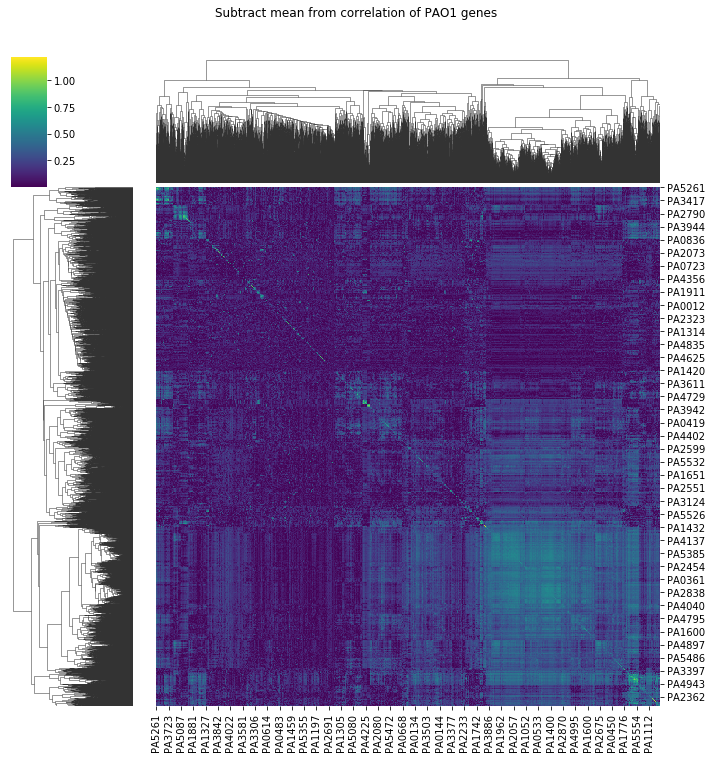

In [70]:
# Plot heatmap
plt.figure(figsize=(20, 20))
h9 = sns.clustermap(pao1_corr_mean_subtract.abs(), cmap="viridis")
h9.fig.suptitle("Subtract mean from correlation of PAO1 genes", y=1.05)

Text(0.5, 1.05, 'Subtract mean from correlation of PA14 genes')

<Figure size 1440x1440 with 0 Axes>

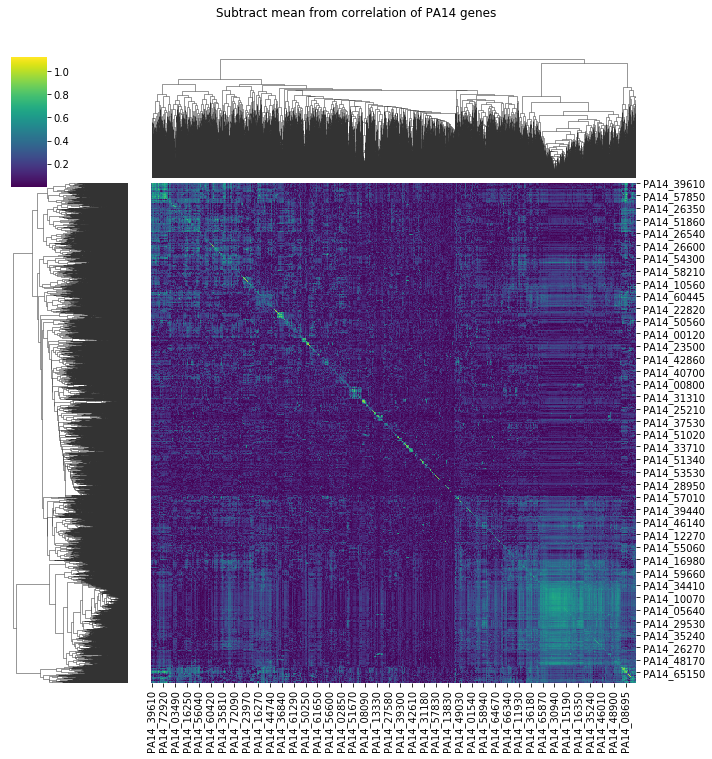

In [72]:
# Plot heatmap
plt.figure(figsize=(20, 20))
h10 = sns.clustermap(pa14_corr_mean_subtract.abs(), cmap="viridis")
h10.fig.suptitle("Subtract mean from correlation of PA14 genes", y=1.05)

**Takeaway:**

* PCA vs SVD

    Given $ X W = Z$.

    The goal of **Principal Component Analysis (PCA)** is to find a weight matrix ($W$) that reduces the data into a low dimensional space that captures the as much information from our input data, $X$, as possible. In other words, we want to find a $W$ that captures as much of the variance in the original data as possible.

    We can use the covariance matrix to describe the input data $X$. $Cov(X)$ is a symmetric matrix that has variances along the diagonal (i.e. spread of the data) and covariances on the off diagonal (orientation of the data).

    We can factorize $Cov(X) = VDV^T$, where $V$ are the eigenvectors, which represent the direction of variance in our data. $V$ are the our principal components to project our data onto. So the weight matrix is composed of these principal components. And when you multiple $XW = XVD = Z$, which is our data projected onto the most variable directions

    **Singular Value Decomposition (SVD)** is a way to factorize your matrix, $X^{mxn}$ into singular vectors and singular values: $X = U \Sigma V^*$

    In our case $X$ is **gene x sample** and then the columns of $U$ are the left singular vectors; $\Sigma$ (eigengene x eigensample) has singular values and is diagonal (mode amplitudes); and $V^T$ has rows that are the right singular vectors.

    Overall, PCA is performing SVD but using the covariance matrix as input. Using the covariance matrix as the input means that the data is centered (i.e. mean is 0). So there is no difference and we might want to use SVD in this case because there is an associated publication to cite.


* log transform will compress the data so that highly variable genes don't dominant the correlation.

* Subtracting the mean correlation score is trying to account for a baseline signal that is present in the data. This still results in fairly large clusters.

Based on this exploration, we will use log transform + SVD correlation matrix to identify clusters.